# Analyse des données du PIM

## Extraction des données

### Préambule technique

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# imports and customization of diplay
import io
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatch

from src.pimapi import Requester

In [3]:
# monkeypatch _repr_latex_ for better inclusion of dataframes output in report
def _repr_latex_(self, size='scriptsize',):
    return(f"\\resizebox{{\\linewidth}}{{!}}{{\\begin{{{size}}}\\centering{{{self.to_latex()}}}\\end{{{size}}}}}")
pd.DataFrame._repr_latex_ = _repr_latex_

### Récupération des données

Le requêtage des données dans le PIM s'appuie sur la classe `Requester` du module pimapi.

In [5]:
requester = Requester('prd')
# Let's fetch the full content of PIM system
requester.fetch_all_from_PIM()
requester.result

Done


[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

A ce stade, les données sont chargées en mémoire sous la forme de fichiers JSON. La conversion des données récupérées par l'API se fait via la méthode `result_to_dataframe` de la classe `Requester`.

In [6]:
df = requester.result_to_dataframe()

## Définitions pour les mises en formes

### Descriptifs longs

On définit un dictionnaire permettant de "traduire" les codes de champs en libellés long.

In [7]:
lab = {
    'code': 'Code produit', 
    'supplier': 'Code fournisseur',
    'type': 'Type de produit',
    'GTIN': 'GTIN',
    'base_unit': 'Unité de base', 
    'net_weight': 'Poids net',
    'gross_weight': 'Poids brut', 
    'dry_weight': 'Poids net égoutté',
    'volume': 'Volume',
    'total_life': 'Durée de vie totale',
    'remaining_life': 'Durée minimale restante',
    'type_cons': 'Type de conservation',
    'before_open': 'Conservation avant ouv.',
    'after_open': 'Convervation après ouv.',
    'cons_temp': 'Température',  
    'temp_des': 'Libellé temporaire',
    'supplier_des': 'Désignation produit fournisseur',
    'supplier_code': 'Code interne fournisseur',
    'brand': 'Marque commerciale',
    'regulatory_des': 'Dénomination réglementaire',
    'properties.pprodi:supplierDesignation': 'Désignation produit fournisseur',
    'properties.pprodc:ingredientsList': "Liste d'ingrédients",
}

### Champs interessants

On liste également les champs intéressants pour un affichage plus court du dataframe.

In [12]:
def_fields = {'properties.vig:code': 'code',
              'properties.psec:supplierCode': 'supplier',
              'properties.pprodtop:typeOfProduct': 'type',
              'properties.pprodi:gtin': 'gtin',
              'properties.pprodi:supplierDesignation': 'designation'}
df.rename(def_fields, axis=1).loc[:, list(def_fields.values())].sample(4)

,code,supplier,type,type,gtin,designation
uid,,,,,,
dbe6bb33-9067-4033-a6e7-b23799b052cc,PIMP-0000011355,PIMF-0000000283,pomProduct,hygiene,3342690158379,Kit part dessert rond fond noir et couvercle c...
d702e415-9b92-4e00-9052-14e0c10dca97,PIMP-0000007911,PIMF-0000000357,pomProduct,grocery,5000189327290,Quality street en boîte 480 g QUALITY STREET
3677fd51-26d2-4e3e-899b-8ce3ddc7dfac,PIMP-0000005604,PIMF-0000000255,pomProduct,nonAlcoholicDrink,3180290022177,Sirop de miel en bouteille verre 1 L GIFFARD
a0b41419-ddd6-47d6-8cf3-77501a7c4ccd,PIMP-0000001185,PIMF-0000000283,pomProduct,hygiene,3342690088829,#Cuillere plate nr sac (50U)x24 AF


## Description des attributs des produit

### Volumétrie des attributs

On constate que chaque produit porte un très grand nombre d'attributs : 

In [13]:
print('Count of columns in df:', len(df.columns))
print('\nInfo of df:')
df.info()

Count of columns in df: 487

Info of df:
<class 'pandas.core.frame.DataFrame'>
Index: 13300 entries, afee12c7-177e-4a68-9539-8cbb68442503 to 6dfce29e-fd4c-4670-9f9c-5c02a5b4d52a
Columns: 487 entries, entity-type to properties.notif:notifications
dtypes: bool(12), float64(60), int64(2), object(413)
memory usage: 48.5+ MB


De plus, de par la nature hiérarchique du format JSON, certains attributs dits "multivalués" sont parfois stockés sous forme de liste dans le dataframe "à plat".
Par exemple, on peut voir que le pays de transformation, ou les facettes, peuvent être multivalués.

In [14]:
df.loc[['609af223-2f14-4f83-a553-cef276f2eca7',
        'c94013e4-0dca-441a-85c1-0b29ecb54d0a',
        '82d1af25-2bdd-4315-9670-67784b70dfa7'],
       ['properties.pprodg:transfoCountries',
        'facets']]

,properties.pprodg:transfoCountries,facets
uid,,
609af223-2f14-4f83-a553-cef276f2eca7,"[PL, FR, ES]","[Versionable, Folderish, Commentable, beginnin..."
c94013e4-0dca-441a-85c1-0b29ecb54d0a,"[DE, NO, BE, RU, CH, BG, LT, GR, FR, UA, HU, E...","[endMigration, Versionable, Folderish, Comment..."
82d1af25-2bdd-4315-9670-67784b70dfa7,[FR],"[endMigration, Versionable, Folderish, Comment..."


De plus, certains attributs sont dits "complexes", car chacune des valeurs de la liste est elle-même un dictionnaire d'attribut.
La combinaison des deux, des attributs "complexes multivalués" existe également. On a alors une liste de dictionnaires. On peut comme ceci imbriquer des niveaux jusqu'à n'importe quelle profondeur.

C'est par exemple le cas des labels qui sont multivalués (un produit peut porter plusieurs labels), qui sont des complexes portant :
- le type de label (bio, Label Rouge, ...)
- la date de fin de validité du label (si applicable)
- le fichier de certification du label (si applicable), qui est lui-même un complexe...


In [15]:
multilabel_ds = df.loc[df['properties.pprodl:labels'].apply(len) > 1, 'properties.pprodl:labels']
for uid, label_list in multilabel_ds.head(3).iteritems():
    print('product uid:', uid)
    for cpt, label in enumerate(label_list):
        print('\n\tlabel', cpt + 1, ':')
        for key, val in label.items():
            print('\t\t', key, ':', val)
    print('-------------------------------------')    

product uid: 41e2b3ca-2c56-4404-8381-352943c9bcef

	label 1 :
		 labelCertificateEndDate : None
		 typeOfLabel : 20
		 labelCertificateFile : {'name': 'San Marzano Statement_12.03.20.pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '847073d2dd4afd83bb1cd63739d6f75f', 'length': '175829', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/default/41e2b3ca-2c56-4404-8381-352943c9bcef/pprodl:labels/0/labelCertificateFile/San%20Marzano%20Statement_12.03.20.pdf?changeToken=130-0'}

	label 2 :
		 labelCertificateEndDate : None
		 typeOfLabel : 20
		 labelCertificateFile : {'name': 'Agro Qualita - New Document 22-Mag-2020 18-57-21(1).pdf', 'mime-type': 'application/pdf', 'encoding': None, 'digestAlgorithm': 'MD5', 'digest': '4ec126e8b458e66fd5614f253aa4fb91', 'length': '1632788', 'data': 'https://produits.groupe-pomona.fr/nuxeo/nxfile/default/41e2b3ca-2c56-4404-8381-352943c9bcef/pprodl:labels/1/labelCertificateFile/Agro%20Qualita%20-%20New%20Docu

### Description des principaux attributs

On commence par déclarer des utilitaires permettant de mettre en forme les représentations.

In [16]:
# Defining main data to explore
mappings = {
    'identification': {
      'properties.vig:code': 'code',
      'properties.psec:supplierCode': 'supplier',
      'properties.pprodtop:typeOfProduct': 'type',
      'properties.pprodi:gtin': 'GTIN',
    },
    'dimensions': {
        'properties.pprodtop:baseUnit': 'base_unit',
        'properties.pprodg:netWeight': 'net_weight',
        'properties.pprodg:grossWeight': 'gross_weight',
        'properties.pprodg:dryWeight': 'dry_weight',
        'properties.pprodg:volume': 'volume',
    },
    'conservation': {
        'properties.pprodg:totalLife': 'total_life',
        'properties.pprodg:guaranteedLife': 'remaining_life',
        'properties.pprodq:typeOfConservation': 'type_cons',
        'properties.pprodq:conservationBeforeOpening': 'before_open',
        'properties.pprodq:conservationAfterOpening': 'after_open',
        'properties.pprodq:conservationTemperature': 'cons_temp',
    }, 
    'designation': {
        'properties.pprodi:temporaryUnitLabel': 'temp_des',
        'properties.pprodi:supplierDesignation': 'supplier_des',
        'properties.pprodi:internalSupplierProductCode': 'supplier_code',
        'properties.pprodg:supplierCommercialBrand': 'brand',
        'properties.pprodg:regulatoryName': 'regulatory_des',   
    }
  }

# Helper function to transform pandas `to_latex` method output to a tabularx env instead.
def to_tabularx(stringio):
    text = stringio.getvalue()
    text = text.replace(r'\begin{tabular}', r'\begin{tabularx}{\linewidth}')
    text = text.replace(r'\end{tabular}',r'\end{tabularx}')
    return(text)

# Function that saves dataframe as Latex tabularx files as input
def save_to_disk(df, path, lab=lab, tex_label=None):
    text = io.StringIO()
    c_format = 'l' + 'X' * len(df.columns)
    (df.rename(lab, axis=1)
       .to_latex(text,
                 bold_rows=True,
                 column_format=c_format,
                 na_rep='-',
                 label=tex_label,
                 ))    
    with open(path, mode='w') as file:
        file.write(to_tabularx(text))    

### Analyses spécifiques : Statuts

On commence par s'intéresser aux différents statuts des produits.
On commence récupérer certaines valeurs de facettes intéressantes : 
- "begginingMigration": elle signifie que le produit a été repris du système historique (le GIP)
- "endMigration": elle signifie que le produit qui a été créé par reprise fait l'objet d'un processus complet de récupération des données et de contrôle par Pomona

In [17]:
df['begin_mig'] = df['facets'].apply(lambda x: 'beginningMigration' in x)
df['end_mig'] = df['facets'].apply(lambda x: 'endMigration' in x)

(df.loc[:, ['begin_mig', 'end_mig']]
   .reset_index()
   .pivot_table(values='uid', 
                index=['begin_mig'],
                aggfunc='count',
                columns='end_mig',
                fill_value=0,
               )
   .rename({True: 'Créé au démarrage', False: 'Créé après le démarrage'}, axis=0)
   .rename({True: 'Facette fin de migration : Oui', False: 'Facette fin de migration : Non'}, axis=1)
).to_latex(
#     Path('..') / 'tbls' / 'migration_status.tex',    
    index_names=False,
    column_format='lcc',
    bold_rows=True,
)

print(
(df.loc[:, ['begin_mig', 'end_mig']]
   .reset_index()
   .pivot_table(values='uid', 
                index=['begin_mig'],
                aggfunc='count',
                columns='end_mig',
                fill_value=0,
               )
   .rename({True: 'Créé au démarrage', False: 'Créé après le démarrage'}, axis=0)
   .rename({True: 'Facette fin de migration : Oui', False: 'Facette fin de migration : Non'}, axis=1)
)
)

end_mig                  Facette fin de migration : Non  Facette fin de migration : Oui
begin_mig                                                                              
Créé après le démarrage                            1745                               0
Créé au démarrage                                  7177                            4378


On peut également voir les statuts courants des produits dans le PIM.

In [18]:
df['state'].value_counts().to_frame().to_latex(
#     Path('..') / 'tbls' / 'products_status.tex',
    column_format = 'lc',
    bold_rows=True,
)
print(df['state'].value_counts())

product.validate                          6230
product.waiting.supplier.validation       4683
product.waiting.pomona.validation.niv3    1080
product.correct                            662
product.controlAnoMinor                    237
product.waiting.sending.supplier           201
product.controlQualityInProgress           108
product.controlWaitingPomonaValidation      35
product.waiting.pomona.validation.niv2      28
product.waiting.pomona.validation           20
product.inactive                            12
product.validate.reserve                     3
product.controlAnoMajor                      1
Name: state, dtype: int64


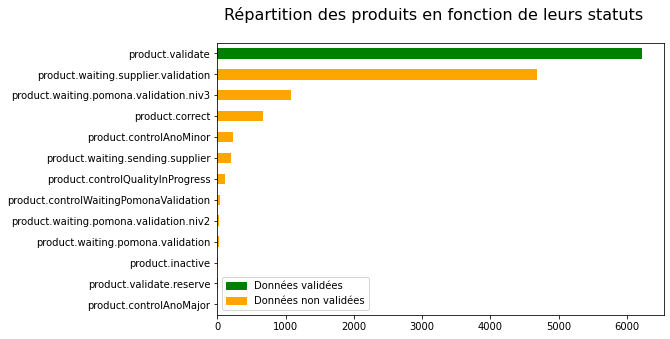

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
color = ['orange'] * len(df['state'].value_counts())
color[-1] = 'g'
incorrect_data = mpatch.Patch(color='orange', label='Données non validées')
correct_data = mpatch.Patch(color='g', label='Données validées')
df['state'].value_counts().sort_values().plot.barh(ax=ax, color=color)
fig.suptitle('Répartition des produits en fonction de leurs statuts',
             fontsize=16)
ax.legend(handles=[correct_data, incorrect_data])
# fig.savefig(Path('..') / 'img' / 'products_status.png', bbox_inches='tight')

On calcule un statut spécifique à la validité des données en combinant le statut de migration et le statut du produit.

In [20]:
migration_mask = df.loc[:, 'end_mig'] | ~df.loc[:, 'begin_mig']
status_mask = (df.loc[:, 'state'] == 'product.validate')
df['data_ok'] = migration_mask & status_mask

In [21]:
cur_df = (df.loc[:, 'data_ok']
            .value_counts()
            .rename({False: 'Hors qualité', True: 'En qualité'})
            .rename('Répartition produit par qualité')
            .to_frame()
         )

cur_df.to_latex(
#                 Path('..') / 'tbls' / 'products_quality.tex',
                bold_rows=True,
                column_format='lc',
                na_rep='-',
                index=True,
                index_names=True,
                )

cur_df

,Répartition produit par qualité
Hors qualité,8718
En qualité,4582


In [22]:
(df.groupby('data_ok')
    [['properties.pprodq:conservationBeforeOpening',
      'properties.pprodg:guaranteedLife']]
    .describe(include='all')
    .stack()
)

properties.pprodq:conservationBeforeOpening  properties.pprodg:guaranteedLife
data_ok                                                                                     
False   count                                         6361                       6060.000000
        unique                                           6                               NaN
        top                             ambientTemperature                               NaN
        freq                                          5698                               NaN
        mean                                           NaN                        346.446700
        std                                            NaN                        372.476931
        min                                            NaN                          0.000000
        25%                                            NaN                        160.000000
        50%                                            NaN                        270.000000
        75%                                            NaN                        480.000000
        max                                            NaN                       9999.000000
True    count                                         3660                       3462.000000
        unique                                           7                               NaN
        top                             ambientTemperature                               NaN
        freq                                          2553                               NaN
        mean                                           NaN                        360.798671
        std                                            NaN                        392.404169
        min                                            NaN                          0.000000
        25%                                            NaN                        180.000000
        50%                                            NaN                        360.000000
        75%                                            NaN                        480.000000
        max                                            NaN                       9999.000000

### Exports des exemples et des descriptions des données structurées

On boucle sur les différents mappings, et on les sauvegardes dans des tableaux latex pour intégration au rapport.

In [23]:
df_dict = dict()

for map_type, mapping in mappings.items():
    cur_df = df.loc[:, list(mapping.keys()) + ['data_ok']].rename(mapping, axis=1).fillna(np.nan)
    df_dict[map_type] = cur_df.copy()
    desc = cur_df.groupby('data_ok').describe(include='all').stack()
    samp = cur_df.sample(n=5, random_state=42)
    print(map_type)
    print(samp.rename(lab, axis=1))
    print('---------------------------------------------------')
    print(desc.rename(lab, axis=1)
              .round(3)
         )
    print('---------------------------------------------------')
    
    # Writing dataframes to .tex files
    text = io.StringIO()
    c_format = 'l' + 'X' * len(cur_df.columns)
    (samp.rename(lab, axis=1)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-'
                   ))
#     with open(Path('..') / 'tbls' / ('Exemple '+ map_type +'.tex'), mode='w') as file:
#         file.write(to_tabularx(text))

    text = io.StringIO()    
    (desc.rename(lab, axis=1)
         .rename({False: 'Hors qualité', True: 'En qualité'})
         .round(3)
         .to_latex(text,
                   bold_rows=True,
                   column_format=c_format,
                   na_rep='-',
                   #index_names=False,
                   multirow=True,
                   ))
#     with open(Path('..') / 'tbls' / ('Desc '+ map_type +'.tex'), mode='w') as file:
#         file.write(to_tabularx(text))
    

identification
                                         Code produit Code fournisseur Type de produit           GTIN  \
uid                                                                                                     
0891b705-0b7d-43ea-bab3-9df5875b8a96  PIMP-0000008707  PIMF-0000000018         grocery  3123070402608   
731bf4e6-2380-4ce4-a859-0d084f3006cd  PIMP-0000001308  PIMF-0000000357         grocery  7613031886999   
d92860c1-c252-4aee-82fe-a471de719af6  PIMP-0000003646  PIMF-0000000287         grocery  3083681003338   
ebbdbd6b-ec4e-46b1-acbb-79ba0b68c1c5  PIMP-0000011491  PIMF-0000000448         hygiene  3573972384302   
5717f881-afad-4f96-9c47-a4b597077e5c  PIMP-0000012513  PIMF-0000000565         hygiene  3661679121181   

                                      data_ok  
uid                                            
0891b705-0b7d-43ea-bab3-9df5875b8a96    False  
731bf4e6-2380-4ce4-a859-0d084f3006cd    False  
d92860c1-c252-4aee-82fe-a471de719af6    False  
ebbdbd6b-

designation
                                                           Libellé temporaire  \
uid                                                                             
0891b705-0b7d-43ea-bab3-9df5875b8a96  Morille spéciale en sachet 1 kg ROGER D   
731bf4e6-2380-4ce4-a859-0d084f3006cd  Fonds brun lié demi-glace en boîte 900    
d92860c1-c252-4aee-82fe-a471de719af6  Courgettes cuisinées à la provençale en   
ebbdbd6b-ec4e-46b1-acbb-79ba0b68c1c5  Barquette 2 compartiments bagasse 700 m   
5717f881-afad-4f96-9c47-a4b597077e5c  PAP TOIL MAX JUMB 350M BLC 2P PREDEC X6   

                                                        Désignation produit fournisseur  \
uid                                                                                       
0891b705-0b7d-43ea-bab3-9df5875b8a96        Morille spéciale en sachet 1 kg ROGER DUTRY   
731bf4e6-2380-4ce4-a859-0d084f3006cd  Fonds Brun Lié Demi-Glace CHEF Boîte de 900 g ...   
d92860c1-c252-4aee-82fe-a471de719af6  Courgettes cuisiné

### Analyses spécifiques : GTIN

On peut mettre en évidence les produits qui portent les mêmes GTIN en double. En y jetant un oeil rapide, quelques explications peuvent être trouvées : 
- il peut s'agir d'un changement de code fournisseur (les 2 premières lignes ne portent pas le même code fournisseur)
- il peut s'agir d'un changement de recette côté industriel, qui a décidé de conserver le même GTIN (second couple)
- il peut s'agir d'une erreur, et de produits en doublon dans le système (troisième couple)
- ...

In [24]:
GTIN_mask = (df['properties.pprodi:gtin'] != '') & ~(pd.isna(df['properties.pprodi:gtin']))
dups_mask = df.loc[GTIN_mask, 'properties.pprodi:gtin'].duplicated(keep=False)
examples = (df.loc[GTIN_mask & dups_mask, def_fields.keys()]
              .rename(def_fields, axis=1)
              .sort_values('gtin')
              .head(8))
# save_to_disk(
#              examples,
#              Path('..') / 'tbls' / 'Duplicated_GTIN.tex',
#              lab={},
#              tex_label='tab:dup_gtin',
#             )
print(examples)

                                                 code         supplier     type            gtin  \
uid                                                                                               
4de8ce87-8df5-440c-959d-3d77d59bb4f3  PIMP-0000013159  PIMF-0000000182  grocery   0020176760607   
048712e3-f145-4f40-b8ad-7c0b912983bd  PIMP-0000009515  PIMF-0000000420  grocery   0020176760607   
7e455046-def3-4526-a28b-bc5c0e6e64fc  PIMP-0000011456  PIMF-0000000290  grocery  03344540125906   
a92c6ac5-d5be-4f92-98b3-9f6c588f7613  PIMP-0000013198  PIMF-0000000290  grocery  03344540125906   
27e20042-dc53-46b4-874c-f970db554aec  PIMP-0000001494  PIMF-0000000250  grocery   3011360083845   
66590f04-5eae-4829-b0da-c899a18dd9cb  PIMP-0000010839  PIMF-0000000250  grocery   3011360083845   
02803e27-487a-43e3-9324-9ad1660b63b2  PIMP-0000002338  PIMF-0000000348  grocery   3038353024906   
52d3f309-e402-4931-974c-b6b6fa721aff  PIMP-0000002337  PIMF-0000000348  grocery   3038353024906   

         

Si l'on produit la répartition du nombre de produit portant un GTIN donné dans le système, on obtient :

                     Nb de GTIN
Pdt portant le GTIN            
1                         11134
2                           230
3                            21
4                            20
5                             1


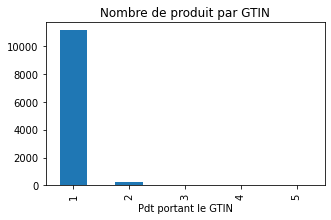

In [25]:
df2 = (df.pivot_table(values='properties.vig:code',
                      index='properties.pprodi:gtin',
                      aggfunc='count')
        .rename({'properties.vig:code': 'code_count'}, axis=1)
      )

df2 = (df2.reset_index()
          .loc[df2.index != '']
          .pivot_table(index='code_count',
                       aggfunc='count',
                       values='code_count')
          .rename({'properties.pprodi:gtin': 'Nb de GTIN'},
                  axis=1)
)

df2.index.rename('Pdt portant le GTIN', inplace=True)

print(df2)

# save_to_disk(df2,
#              Path('..') / 'tbls' / 'gtin_counts.tex')

fig, ax = plt.subplots(figsize=(5,3))
df2.plot(kind='bar', legend=None, title='Nombre de produit par GTIN', ax=ax)
# fig.savefig(Path('..') / 'img' / 'repartition_gtin.png', bbox_inches='tight')

### Analyse spécifique : distribution par fournisseur

On peut représenter la distribution produit, par fournisseur.

In [27]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .reset_index()
            .pivot_table(values=['supplier', 'code'],
                         index='code',
                         aggfunc={'supplier': 'count',
                         'code': 'sum'})
)

# aligning index to have it countinuous
new_idx = pd.RangeIndex(start=1, stop=max(counts.index) + 1)

counts = (counts.reindex(new_idx)
                .fillna(0)
)

counts = pd.concat([counts,
                    counts.cumsum().rename({'code': 'cum_code', 'supplier': 'cum_supplier'},
                                           axis=1),
                   ],
                   axis=1)

for feature in ['supplier', 'code']:
    counts['cump_' + feature] = 100 * counts['cum_' + feature] / counts.loc[:, 'cum_' + feature].iloc[-1]

counts.head(5)

,code,supplier,cum_code,cum_supplier,cump_supplier,cump_code
1,80.0,80.0,80.0,80.0,13.114754,0.601504
2,138.0,69.0,218.0,149.0,24.426230,1.639098
3,180.0,60.0,398.0,209.0,34.262295,2.992481
4,188.0,47.0,586.0,256.0,41.967213,4.406015
5,180.0,36.0,766.0,292.0,47.868852,5.759398


Text(0.5, 0.98, 'Distribution des fournisseurs fonction du nombre de produit par fournisseur')

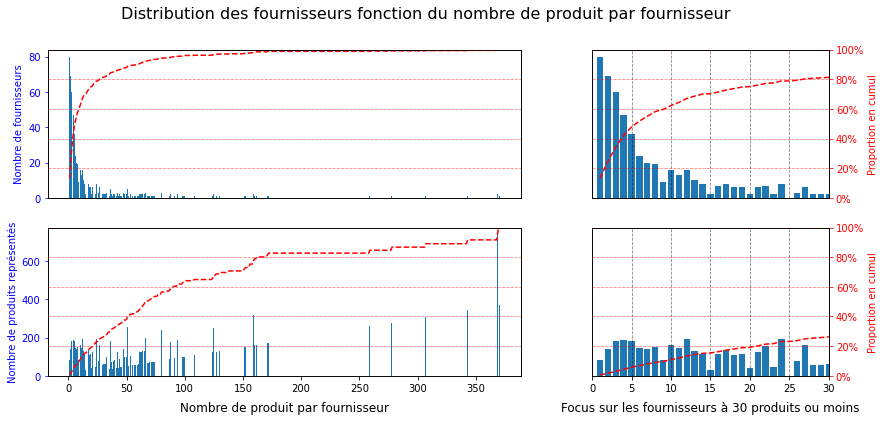

In [28]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(14, 6),
                        gridspec_kw= {'width_ratios': [2, 1]})

axs2 = [[ax.twinx() for ax in axrow] for axrow in axs]

for i, feature in enumerate(['supplier', 'code']):
    axs[i][0].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][0].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][0].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].bar(data=counts.loc[:, feature].reset_index(), x='index', height=feature)
    axs2[i][1].plot('index', 'cump_' + feature, data=counts.loc[:, 'cump_' + feature].reset_index(),
                    color='red', linestyle='--')
    axs2[i][1].grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
    
    axs[i][1].set_xlim(0, 30)
    
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs2[i][j].set_ylim(0, 100)
        # remove all bottom ticks except for bottom line
        # set_yticks does not work as it removes the grid
        if i < len(axs) - 1:
            axs[i][j].set_xticklabels([])
            for tic in axs[i][j].xaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all right ticks except for right column
        # set_yticks does not work as it removes the grid
        if j < len(axs[i]) - 1: 
            axs2[i][j].set_yticklabels([])
            for tic in axs2[i][j].yaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        # remove all left ticks except for first column
        if j > 0: 
            axs[i][j].set_yticks([])
        if j == len(axs[i]) - 1:
            axs2[i][j].tick_params(axis='y', colors='red')
            axs2[i][j].yaxis.set_major_formatter(ticker.PercentFormatter())
            axs2[i][j].set_ylabel('Proportion en cumul', color='red')
            axs[i][j].grid(True, axis='x', color='k', alpha=0.5, linestyle='--')
        if j == 0:
            axs[i][j].tick_params(axis='y', colors='blue')
            if i == 0: 
                axs[i][j].set_ylabel('Nombre de fournisseurs', color='blue')
            if i == 1:
                axs[i][j].set_ylabel('Nombre de produits représentés', color='blue')
axs[1][0].set_xlabel('Nombre de produit par fournisseur', 
                     fontsize=12,
                     labelpad=8,
                    )
axs[1][1].set_xlabel('Focus sur les fournisseurs à 30 produits ou moins', 
                     fontsize=12,
                     labelpad=8,
                    )

fig.suptitle('Distribution des fournisseurs fonction du nombre de produit par fournisseur',
             fontsize=16,
            )

# fig.savefig(Path('..') / 'img' / 'distribution_fournisseurs_par_prd_count.png', bbox_inches='tight')

On peut également représenter le nombre de produits "récupérés" si on prend les fournisseurs par nombre de produits décroissant.

In [30]:
# construction the counts
counts = (df.loc[:, list(def_fields.keys())]
            .rename(def_fields, axis=1)
            .pivot_table(values='code',
                         index='supplier',
                         aggfunc='count')
            .sort_values('code', ascending=False)
)
counts['code_cumsum'] = counts['code'].cumsum()
counts.head(5)

,code,code_cumsum
supplier,,
PIMF-0000000179,370,370
PIMF-0000000250,369,739
PIMF-0000000283,369,1108
PIMF-0000000074,343,1451
PIMF-0000000392,307,1758


Text(0.5, 0.98, '"Rappel" des produits en fonction des fournisseurs')

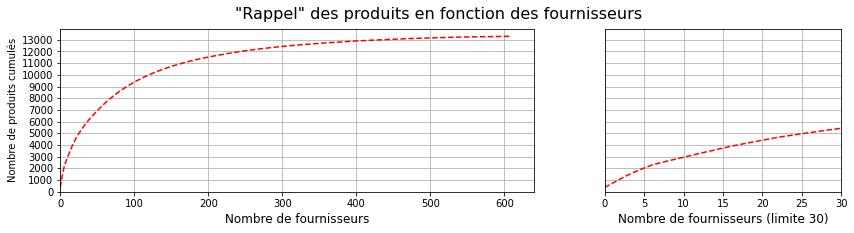

In [31]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(14, 3),
                        gridspec_kw= {'width_ratios': [2, 1]})

for j in range(len(axs)):
    axs[j].plot('index',
                'code_cumsum',
                data=counts.reset_index().reset_index(),
                color='red',
                linestyle='--',
               )
    axs[j].set_xlabel('Nombre de fournisseurs', fontsize=12)
    axs[j].set_ylim(0)
    axs[j].set_xlim(0)
    axs[j].grid(True)
    axs[j].yaxis.set_ticks(np.arange(0, 14000, 1000))

axs[0].set_ylabel('Nombre de produits cumulés')
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Nombre de fournisseurs (limite 30)', fontsize=12)
axs[1].set_yticklabels([])
for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)

fig.suptitle('"Rappel" des produits en fonction des fournisseurs', fontsize=16)

# fig.savefig(Path('..') / 'img' / 'rappel_produit_par_fournisseur.png', bbox_inches='tight')

### Export de quelques désignations et listes d'ingrédients

On exporte quelques désignations pour illuster.

In [33]:
df_des = df_dict['designation']
export_df = (df_des.loc[df_des['data_ok'],
                        ['temp_des',
                         'supplier_des',
                         'supplier_code',
                         'brand',
                         'regulatory_des']]
                   .rename(lab, axis=1)
                   .sample(5, random_state=40)
)
export_df

# Do not overwrite current saved file! 
# It has been corrected manually (midrule was not well placed)
#export_df.to_latex(Path('..') / 'tbls' / 'designation_example.tex',
#                   index=False, 
#                   column_format='p{4cm}p{4cm}p{2cm}p{2cm}p{3cm}',
#                   index_names=False,
#                   )

,Libellé temporaire,Désignation produit fournisseur,Code interne fournisseur,Marque commerciale,Dénomination réglementaire
uid,,,,,
d76f0535-2a1c-40a4-abcc-9cb132cc855c,Riz long étuvé pour risotto et paëlla e,Riz long étuvé pour risotto et paëlla en sac 2...,3039820204104,VIVIEN PAILLE,Riz long étuvé de qualité supérieure
adbcf49f-fc6c-47dd-8339-b6d793524d6f,Compote de pomme-fraise allégée en berl,COMPOTE ALLÉGÉE EN SUCRES POMME FRAISE BERLING...,42033,SAINT MAMET,Compote de pomme fraise allégée en sucres *\n*...
843066e8-9fbb-491d-8c96-2d27846f1335,Boîte avec couvercle 450 cc en sachet d,BOITE COUVERCLE CHALEUR 450 CC,RC450,ALPHA FORM,BOITE COUVERCLE CHALEUR 450 CC
a2bc8bf8-4ca5-4d5c-94e5-d4e9243cd60f,"Café moulu 50% arabica, 50 % robusta en",FILTRE DOSE MIKO REST CO 12X4X65G - 50%A-50%R,509223,MIKO,CAFE MOULU FILTRE DOSE MIKO R. COLLECTIVE
5ae42ed5-454f-4301-9dea-394e64734cf9,Bouillon de légume hyposodé en boîte 80,Bouillon de légume hyposodé en boîte 800 g NEF...,7089,NEFF MADA,Bouillon déshydraté


In [36]:
ingred_mask = df['data_ok'] & ~pd.isna(df['properties.pprodc:ingredientsList'])

sample_ingred = (df.loc[ingred_mask, ['properties.pprodi:supplierDesignation',
                                      'properties.pprodc:ingredientsList']]
                   .rename(lab, axis=1)
                   .sample(10, random_state=42))

with pd.option_context("max_colwidth", 1000):
    pass
#     print(sample_ingred)
#    sample_ingred.to_latex(Path('..') / 'tbls' / 'ingredient_example.tex',
#                           index=False,
#                           index_names=False,
#                           column_format='p{5cm}p{10cm}',
#                           )
sample_ingred

,Désignation produit fournisseur,Liste d'ingrédients
uid,,
0635f409-5543-4260-8d67-b55cf4679d30,Pâte d'arachide en boîte 4/4 DAKATINE,"97,5% ARACHIDES grillées, émulsifiant d'origin..."
9e4e4b6e-4bf9-4950-8427-23ee82527269,Madeleine pur beurre,"BEURRE 26%, OEUFS frais 25 %, farine de BLE te..."
c40d1993-69a2-4500-86ee-a346ac6a921c,Coca-cola en bouteille verre 25 cl COCA-COLA,"Eau gazéifiée, sucre, colorant : E150d, acidif..."
e564f0be-fa60-4a0d-b663-8be4605f0d62,Vinaigre balsamique de Modène en bouteille ver...,"Vinaigre de vin, moût de raisin cuit, colorant..."
69cab499-8541-424e-9fe4-a2389c5f18a3,Carottes râpées en boîte 5/1 EPISAVEURS,"Carottes, eau, sel, acidifiants (acide acétiqu..."
a477326e-38a0-4643-973f-1bac4efa0a70,CÔTES DU RHÔNE ROUGE AOC EN BOUTEILLE 25 CL LE...,VIN contient des SULFITES
1f9e6e3c-fdb3-492d-a142-61c247887a78,STICKS STEVIA 0 CALORIE DADDY 60 GR,"Agent de charge: érythritol, édulcorant: glyco..."
5810e22e-01bb-414d-b3dd-db1a29edcbcd,JUS DE PAMPLEMOUSSE EN BRIQUE 1L BRICI,Jus de pamplemousse à base de jus de pamplemou...
fdec3861-1607-49a5-a396-d74d7fd51273,Jus de pomme en briquette 20 cl PLEIN FRUIT,Jus de pomme à base de concentré


## Analyse de la complétude des pièces jointes

On jette un oeil au niveau de renseignement des pièces jointes dans le PIM.

In [38]:
file_df = requester.file_report_from_result(mapping={'uid': 'uid'}, index='uid', record_path='entries')
file_df.sample(5)

,has_supplierdatasheet,has_supplierlabel
uid,,
0ec61fa6-238f-4383-b175-7686edaf9bbb,True,True
1748bfc2-e1b1-4093-9390-6418f76047f5,True,True
c8f655ce-3efa-4e4c-840a-b213b38ccc6e,True,True
4f3c1903-f883-4f24-a9b9-894408dcfb2d,True,False
cacdd8af-8814-47ef-830d-f463eb8fd04f,True,True


In [39]:
file_df = file_df.join(df)

In [41]:
total_df = file_df.groupby('properties.pprodtop:typeOfProduct').size().to_frame(name='total')
new_idx = pd.MultiIndex.from_tuples([('total', 'total')])
total_df.columns = new_idx
print(total_df)

                                  total
                                  total
properties.pprodtop:typeOfProduct      
alcoholicDrink                      607
chemistry                           467
grocery                            8793
hygiene                            2526
nonAlcoholicDrink                   907


In [42]:
report_df = (
file_df.pivot_table(values=['has_supplierdatasheet', 'has_supplierlabel'],
                    columns=['data_ok', ],
                    index=['properties.pprodtop:typeOfProduct'],
                    aggfunc=['sum', 'count'],
                    margins=True,
                   )
)
report_df2 = report_df.swaplevel(axis=1, i=0, j=2).sort_index(axis=1).stack([0, 1])
report_df2['percent'] = report_df2['sum'] / report_df2['count']
report_df3 = report_df2.unstack(level=[-2, -1]).swaplevel(axis=1, i=0, j=1).swaplevel(axis=1, i=2, j=1).sort_index(axis=1)
report_df3.columns.rename(['data_ok', 'attached', 'func'], inplace=True)
report_df3

data_ok                                           False                                                \
attached                          has_supplierdatasheet                   has_supplierlabel             
func                                              count   percent     sum             count   percent   
properties.pprodtop:typeOfProduct                                                                       
All                                                8718  0.845033  7367.0              8718  0.323239   
alcoholicDrink                                      353  0.835694   295.0               353  0.206799   
chemistry                                           329  0.936170   308.0               329  0.389058   
grocery                                            5742  0.832637  4781.0              5742  0.344131   
hygiene                                            1743  0.872633  1521.0              1743  0.253586   
nonAlcoholicDrink                                   551  0.838475   462.0               551  0.361162   

data_ok                                                    True                                    \
attached                                  has_supplierdatasheet                 has_supplierlabel   
func                                  sum                 count percent     sum             count   
properties.pprodtop:typeOfProduct                                                                   
All                                2818.0                  4582     1.0  4582.0              4582   
alcoholicDrink                       73.0                   254     1.0   254.0               254   
chemistry                           128.0                   138     1.0   138.0               138   
grocery                            1976.0                  3051     1.0  3051.0              3051   
hygiene                             442.0                   783     1.0   783.0               783   
nonAlcoholicDrink                   199.0                   356     1.0   356.0               356   

data_ok                                                               All                     \
attached                                            has_supplierdatasheet                      
func                                percent     sum                 count   percent      sum   
properties.pprodtop:typeOfProduct                                                              
All                                0.979267  4487.0                 13300  0.898421  11949.0   
alcoholicDrink                     1.000000   254.0                   607  0.904448    549.0   
chemistry                          1.000000   138.0                   467  0.955032    446.0   
grocery                            0.996395  3040.0                  8793  0.890709   7832.0   
hygiene                            0.896552   702.0                  2526  0.912114   2304.0   
nonAlcoholicDrink                  0.991573   353.0                   907  0.901874    818.0   

data_ok                                                                
attached                          has_supplierlabel                    
func                                          count   percent     sum  
properties.pprodtop:typeOfProduct                                      
All                                           13300  0.549248  7305.0  
alcoholicDrink                                  607  0.538715   327.0  
chemistry                                       467  0.569593   266.0  
grocery                                        8793  0.570454  5016.0  
hygiene                                        2526  0.452890  1144.0  
nonAlcoholicDrink                               907  0.608600   552.0

In [43]:
type_index = pd.Index(['grocery', 'nonAlcoholicDrink', 'alcoholicDrink', 'hygiene', 'chemistry', 'All'], name='type')
idxs = [[True, False, 'All'], ['has_supplierdatasheet', 'has_supplierlabel'], ['sum', 'count', 'percent']]
col_index = pd.MultiIndex.from_product(idxs, names=['data_ok', 'attached', 'func'])
report_df4 = report_df3.reindex(col_index, axis=1).reindex(type_index)
report_df4

data_ok                            True                                                  \
attached          has_supplierdatasheet               has_supplierlabel                   
func                                sum count percent               sum count   percent   
type                                                                                      
grocery                          3051.0  3051     1.0            3040.0  3051  0.996395   
nonAlcoholicDrink                 356.0   356     1.0             353.0   356  0.991573   
alcoholicDrink                    254.0   254     1.0             254.0   254  1.000000   
hygiene                           783.0   783     1.0             702.0   783  0.896552   
chemistry                         138.0   138     1.0             138.0   138  1.000000   
All                              4582.0  4582     1.0            4487.0  4582  0.979267   

data_ok                           False                                                    \
attached          has_supplierdatasheet                 has_supplierlabel                   
func                                sum count   percent               sum count   percent   
type                                                                                        
grocery                          4781.0  5742  0.832637            1976.0  5742  0.344131   
nonAlcoholicDrink                 462.0   551  0.838475             199.0   551  0.361162   
alcoholicDrink                    295.0   353  0.835694              73.0   353  0.206799   
hygiene                          1521.0  1743  0.872633             442.0  1743  0.253586   
chemistry                         308.0   329  0.936170             128.0   329  0.389058   
All                              7367.0  8718  0.845033            2818.0  8718  0.323239   

data_ok                             All                                                      
attached          has_supplierdatasheet                  has_supplierlabel                   
func                                sum  count   percent               sum  count   percent  
type                                                                                         
grocery                          7832.0   8793  0.890709            5016.0   8793  0.570454  
nonAlcoholicDrink                 818.0    907  0.901874             552.0    907  0.608600  
alcoholicDrink                    549.0    607  0.904448             327.0    607  0.538715  
hygiene                          2304.0   2526  0.912114            1144.0   2526  0.452890  
chemistry                         446.0    467  0.955032             266.0    467  0.569593  
All                             11949.0  13300  0.898421            7305.0  13300  0.549248

In [44]:
### WARNING !!! This tex export requires some manual adjustments to have
### multiindex headers centered !!!

(
report_df4.rename({'has_supplierdatasheet': 'Fiche technique',
                   'has_supplierlabel': 'Etiquette',
                   True: 'En qualité',
                   False: 'Hors qualité',
                   'All': 'Total',
                   'sum': 'cpt',
                   'count': 'sur',
                   'percent': '%',
                  }, axis=1)
          .rename({'grocery': 'Epicerie',
                   'nonAlcoholicDrink': 'Boissons',
                   'alcoholicDrink': 'Alcools',
                   'hygiene': 'Hygiène',
                   'chemistry': 'Chimie', 
                   'All': 'Total'})
          .to_latex(
                    #Path('..') / 'tbls' / 'attached_files_counts.tex',
                    column_format='|l|ccc|ccc|ccc|ccc|ccc|ccc|',
                    bold_rows=True, 
                    index_names=False,
                    formatters=[lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                               ]
                   )
)

'\\begin{tabular}{|l|ccc|ccc|ccc|ccc|ccc|ccc|}\n\\toprule\n{} & \\multicolumn{6}{l}{En qualité} & \\multicolumn{6}{l}{Hors qualité} & \\multicolumn{6}{l}{Total} \\\\\n{} & \\multicolumn{3}{l}{Fiche technique} & \\multicolumn{3}{l}{Etiquette} & \\multicolumn{3}{l}{Fiche technique} & \\multicolumn{3}{l}{Etiquette} & \\multicolumn{3}{l}{Fiche technique} & \\multicolumn{3}{l}{Etiquette} \\\\\n{} &             cpt &  sur &    \\% &       cpt &  sur &    \\% &             cpt &  sur &   \\% &       cpt &  sur &   \\% &             cpt &   sur &   \\% &       cpt &   sur &   \\% \\\\\n\\midrule\n\\textbf{Epicerie} &            3051 & 3051 & 100\\% &      3040 & 3051 &  99\\% &            4781 & 5742 & 83\\% &      1976 & 5742 & 34\\% &            7832 &  8793 & 89\\% &      5016 &  8793 & 57\\% \\\\\n\\textbf{Boissons} &             356 &  356 & 100\\% &       353 &  356 &  99\\% &             462 &  551 & 83\\% &       199 &  551 & 36\\% &             818 &   907 & 90\\% &       552 &   907 

## Analyse de la complétude des listes d'ingrédients

On peut aussi faire l'analyse de la complétude des listes d'ingrédients.

In [50]:
df['has_ingredients'] = ~df['properties.pprodc:ingredientsList'].isna()

In [63]:
report_df = (
df.pivot_table(values=['has_ingredients'],
               columns=['data_ok', ],
               index=['properties.pprodtop:typeOfProduct'],
               aggfunc=['sum', 'count'],
               margins=True,
              )
)
report_df2 = report_df.swaplevel(axis=1, i=0, j=2).sort_index(axis=1).stack([0, 1])
report_df2['percent'] = report_df2['sum'] / report_df2['count']
report_df2
report_df3 = report_df2.unstack(level=[-2, -1]).swaplevel(axis=1, i=0, j=1).swaplevel(axis=1, i=2, j=1).sort_index(axis=1)
report_df3.columns.rename(['data_ok', 'attached', 'func'], inplace=True)
report_df3.columns = report_df3.columns.droplevel(level=1)
type_index = pd.Index(['grocery', 'nonAlcoholicDrink', 'alcoholicDrink', 'hygiene', 'chemistry', 'All'], name='type')
idxs = [[True, False, 'All'], ['sum', 'count', 'percent']]
col_index = pd.MultiIndex.from_product(idxs, names=['data_ok', 'func'])
report_df4 = report_df3.reindex(col_index, axis=1).reindex(type_index)
report_df4

data_ok              True                   False                     All                 
func                  sum count   percent     sum count   percent     sum  count   percent
type                                                                                      
grocery            3051.0  3051  1.000000  5317.0  5742  0.925984  8368.0   8793  0.951666
nonAlcoholicDrink   356.0   356  1.000000   504.0   551  0.914701   860.0    907  0.948181
alcoholicDrink      254.0   254  1.000000   259.0   353  0.733711   513.0    607  0.845140
hygiene               0.0   783  0.000000     0.0  1743  0.000000     0.0   2526  0.000000
chemistry             0.0   138  0.000000     3.0   329  0.009119     3.0    467  0.006424
All                3661.0  4582  0.798996  6083.0  8718  0.697752  9744.0  13300  0.732632

In [64]:
### WARNING !!! This tex export requires some manual adjustments to have
### multiindex headers centered !!!

(
report_df4.rename({'has_supplierdatasheet': 'Fiche technique',
                   'has_supplierlabel': 'Etiquette',
                   True: 'En qualité',
                   False: 'Hors qualité',
                   'All': 'Total',
                   'sum': 'cpt',
                   'count': 'sur',
                   'percent': '%',
                  }, axis=1)
          .rename({'grocery': 'Epicerie',
                   'nonAlcoholicDrink': 'Boissons',
                   'alcoholicDrink': 'Alcools',
                   'hygiene': 'Hygiène',
                   'chemistry': 'Chimie', 
                   'All': 'Total'})
          .to_latex(
                    #Path('..') / 'tbls' / 'ingredients_counts.tex',
                    column_format='|l|ccc|ccc|ccc|',
                    bold_rows=True, 
                    index_names=False,
                    formatters=[lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                                lambda x: str(int(x)),
                                lambda x: str(int(x)),
                                lambda x: f'{int(x * 100):d}%',
                               ]
                   )
)

(
report_df3.rename({'has_supplierdatasheet': 'Fiche technique',
                   'has_supplierlabel': 'Etiquette',
                   True: 'En qualité',
                   False: 'Hors qualité',
                   'All': 'Total',
                   'sum': 'cpt',
                   'count': 'sur',
                   'percent': '%',
                  }, axis=1)
          .rename({'grocery': 'Epicerie',
                   'nonAlcoholicDrink': 'Boissons',
                   'alcoholicDrink': 'Alcools',
                   'hygiene': 'Hygiène',
                   'chemistry': 'Chimie', 
                   'All': 'Total'})
)

data_ok                           Hors qualité                   En qualité                    Total  \
func                                       sur         %     cpt        sur         %     cpt    sur   
properties.pprodtop:typeOfProduct                                                                      
Total                                     8718  0.697752  6083.0       4582  0.798996  3661.0  13300   
Alcools                                    353  0.733711   259.0        254  1.000000   254.0    607   
Chimie                                     329  0.009119     3.0        138  0.000000     0.0    467   
Epicerie                                  5742  0.925984  5317.0       3051  1.000000  3051.0   8793   
Hygiène                                   1743  0.000000     0.0        783  0.000000     0.0   2526   
Boissons                                   551  0.914701   504.0        356  1.000000   356.0    907   

data_ok                                              
func                                      %     cpt  
properties.pprodtop:typeOfProduct                    
Total                              0.732632  9744.0  
Alcools                            0.845140   513.0  
Chimie                             0.006424     3.0  
Epicerie                           0.951666  8368.0  
Hygiène                            0.000000     0.0  
Boissons                           0.948181   860.0